### Problem:
$$
\begin{cases}
-\Delta u = 2\sin(x_1)\sin(x_2) &\text{on } \Omega\\
u = \sin(x_1)\sin(x_2) &\text{on } \partial\Omega
\end{cases}$$

where $\Omega = [-1,1]^2$. The corresponding variational problem is given by:

$$\mathcal{J}(u) = \int_\Omega \big( \frac{1}{2}|\nabla u|^2-2\sin(x_1)\sin(x_2)u \big)\text{d}V$$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cbook as cbook
import matplotlib.patches as patches
from ipywidgets import IntProgress
from IPython.display import display
import time

--------------------------------------------------------------------------------------------------------------------------------

# Architectures

## Shallow NN, Tanh Activation

In [2]:
class srnn_Tanh(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.input(x))
        x = self.tanh(self.hidden(x))
        x = self.output(x)
        return x

## Shallow NN, ReLU Activation

In [3]:
class srnn_ReLU(nn.Module):
    """
    srnn -- Shallow Ritz Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=0):
        super(srnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        self.input = nn.Linear(in_N, m)
        self.hidden = nn.Linear(m, m)
        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input(x))
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

## Feedforward NN, tanh Activation

In [4]:
class drfnn_Tanh(nn.Module):
    """
    drfnn2 -- Deep Ritz Feedforward Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_Tanh, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.phi = nn.Tanh()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.phi(self.stack[i](x))
        x = self.output(x)
        return x

## Feedforward NN, ReLU Activation

In [5]:
class drfnn_ReLU(nn.Module):
    """
    drnn -- Deep Ritz Feedforward Neural Network

    Implements a network with single hidden layer

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=8):
        super(drfnn_ReLU, self).__init__()
        
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        
        # list for holding all the layers
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle layers to list
        for i in range(depth):
            self.stack.append(nn.Linear(m, m))

        self.output = nn.Linear(m, out_N)
        self.relu = nn.ReLU()

    def forward(self, x):        
        for i in range(len(self.stack)):
            x = self.relu(self.stack[i](x))
        x = self.output(x)
        return x

## Original Residual NN, Tanh Activation

In [13]:
class Block(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N, phi=PowerReLU()):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.Tanh()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [14]:
class drrnn_Tanh(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4, phi=PowerReLU()):
        super(drrnn_Tanh, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

## Original Residual NN, ReLU Activation

In [15]:
class BlockReLU(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N, phi=PowerReLU()):
        super(BlockReLU, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.ReLU()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x

In [16]:
class drrnn_ReLU(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4, phi=PowerReLU()):
        super(drrnn_ReLU, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        #self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(BlockReLU(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

--------------------------------------------------------------------------------------------------------------------------------

# Sampling in $\mathbb{R}^2$

In [22]:
# SQUARE CENTRED AT ORIGIN, SIDE LENGTH 2: \Omega = (-1,1)^2
def get_interior_points_sq(N=128,d=2):
    """
    randomly sample N points from interior of [-1,1]^2
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points_sq(N=32):
    """
    randomly sample N points from boundary of [-1,1]^2
    """
    index1 = torch.rand(N,1) * 2 - 1
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    xb = torch.cat((xb2, xb3, xb4, xb5), dim=0)

    return xb

In [25]:
# ORIGINAL DOMAIN: \Omega = (-1,1)^2 \ [0,1)x{0}
def get_interior_points_original(N=128,d=2):
    """
    randomly sample N points from interior of (-1,1)^2 \ [0,1)x{0}
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points_original(N=32):
    """
    randomly sample N points from boundary of (-1,1)^2 \ [0,1)x{0}
    """
    index = torch.rand(N,1)
    index1 = torch.rand(N,1) * 2 - 1
    xb1 = torch.cat((index, torch.zeros_like(index)), dim=1)
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    xb = torch.cat((xb1, xb2, xb3, xb4, xb5), dim=0)

    return xb

In [34]:
# SWITCHBOARD FOR DOMAINS
def get_points(domain='sq'):
    """
    Switchboard for domains
    """
    if domain == 'original':
        xr = get_interior_points_original()
        xb = get_boundary_points_original()
    else:
        xr = get_interior_points_sq()
        xb = get_boundary_points_sq()
        
    return xr, xb

--------------------------------------------------------------------------------------------------------------------------------

# Initialisation and Training

In [35]:
def weights_init(m):  # Initialise weights
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)      # Initialisation technique using normal dist. introduced by Xavier Glorot
        nn.init.constant_(m.bias, 0.0)        # Initialise bias vectors as zero

--------------------------------------------------------------------------------------------------------------------------------

# 2-Laplacian, $u = sin(x_1)sin(x_2)$, on $\Omega = [-1,1]^2$

In [49]:
def main_example1(domain = 'sq', arch = 'drrnn', epochs = 5000, m = 10, pretrain=0):    
    """
    main -- Training Module

    Trains a chosen model with random sampling in domain and boundary.

    Parameters:
        domain -- domain of the problem
        arch   -- architecture to be used
        m      -- width of layers
    """
    
    save_loss = torch.zeros((epochs//100, 1))     # saving loss and error values as the model is trained
    save_error = torch.zeros((epochs//100, 1))    

    in_N = 2      # Input Dimensions
    #m = 10        # width of hidden layer
    out_N = 1     # Output Dimensions

    device = torch.device('cpu')
    
    if arch == 'srnn_ReLU':
        model = srnn_ReLU(in_N, m, out_N).to(device)
        
    elif arch == 'srnn_Tanh':
        model = srnn_Tanh(in_N, m, out_N).to(device)
        
    elif arch == 'drfnn_ReLU':
        model = drfnn_ReLU(in_N, m, out_N).to(device)
        
    elif arch == 'drfnn_Tanh':
        model = drfnn_Tanh(in_N, m, out_N).to(device)
        
    elif arch == 'drrnn_ReLU':
        model = drrnn_ReLU(in_N, m, out_N).to(device)
        
    else:
        arch = 'drrnn_Tanh'
        model = drrnn_Tanh(in_N, m, out_N).to(device)
        
    
    # Initialise weights
    if pretrain == 1:
        model.load_state_dict(torch.load('pretrained_models/'+domain+'_'+arch+'.mdl'))
    else:
        model.apply(weights_init)  
        
        # PLOT EXAMPLE DATA
        X, Y = get_points(domain)
        plt.scatter(X[:,0],X[:,1])
        plt.scatter(Y[:,0],Y[:,1])
        plt.axis('equal')
        plt.show()
        
    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-3)
    print(model)                                
    
    best_loss, best_error, best_epoch = 100000, 100000, 0          # Tracking best iteration
    
    f = IntProgress(min=0, max=epochs//100) # instantiate the bar
    display(f) # display the bar
    
    for epoch in range(epochs+1):

        # Generate the data set
        xr, xb = get_points(domain)
        #xr = get_interior_points()            
        #xb = get_boundary_points()

        xr = xr.to(device)
        xb = xb.to(device)

        xr.requires_grad_()
        output_r = model(xr)
        output_b = model(xb)
        
        # Compute the gradient term \nabla v
        grads = autograd.grad(outputs=output_r, inputs=xr,
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

        # Integrand of the above variational problem (averaged)
        loss_r = 0.5 * torch.sum(torch.pow(grads, 2),dim=1) - 2*torch.sin(xr[:,:1])*torch.sin(xr[:,1:])*output_r
        loss_r = torch.mean(loss_r)
        
        # Boundary data penalty term
        loss_b = output_b - torch.sin(xb[:,:1])*torch.sin(xb[:,1:])
        loss_b = torch.mean(torch.pow(loss_b,2))
        
        # Combined weighted loss
        loss = 4 * loss_r + 8 * 50 * loss_b
        # 4 = area of region, 8 = length of boundary

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            #print('epoch:', epoch, 'loss:', loss.item(), 'loss_r:', (4 * loss_r).item(), 'loss_b:', (8 * 50 * loss_b).item())
            save_loss[epoch//100 - 1] = loss.item()
            error = torch.sqrt(torch.mean(torch.pow((output_r - torch.sin(xr[:,:1])*torch.sin(xr[:,1:])),2)))
            error = error/torch.sqrt(torch.mean(torch.pow(torch.sin(xr[:,:1])*torch.sin(xr[:,1:]), 2)))
            #print('L2 error:', error.item())
            save_error[epoch//100 - 1] = error.item()
            f.value += 1 # signal to increment the progress bar
            time.sleep(.1)
            
            # Find minimum absolute loss in final 20% of training process
            if epoch > int(4 * epochs / 5):
                #if torch.abs(loss) < best_loss:      # Absolute value of loss
                if (loss.item() < best_loss):         # Most negative value of loss
                    best_loss = loss.item()
                    best_epoch = epoch
                    best_error = error.item()
                    if pretrain == 2:
                        torch.save(model.state_dict(), 'pretrained_models/'+domain+'_'+arch+'.mdl')   
                    torch.save(model.state_dict(), 'saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl')
    print('best epoch:', best_epoch, 'best loss:', best_loss, 'relative L2 error:', best_error)
    
    #if pretrain == 1:
    # Loss and Error profile
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Iterations (100s)')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(save_loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Training Loss and Error Profiles")

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Relative L2 Error From Sample', color=color)  
    ax2.plot(save_error, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    #plt.savefig('example1_'+arch+str(epochs)+'_combined.png')
    #plt.savefig('convergence_plots_relative/'+domain+'_'+arch+str(epochs)+'_combined.png')
    plt.show()

    # plot figure
    model.load_state_dict(torch.load('saved_models/best_'+domain+'_'+arch+str(epochs)+'.mdl'))
    print('load from ckpt!')

    num_points=1001
    x = torch.linspace(-1, 1, num_points)
    Y, X = torch.meshgrid(x, x)

    # CHOOSE DOMAIN
    mask = (X==0) 
    mask = mask + 1
    extent1=[-1, 1, -1, 1]

    # EVALUATE MODEL IN [-1,1]^2
    Z = torch.cat((X.flatten()[:, None], Y.flatten()[:, None]), dim=1)
    Z = Z.to(device)
    with torch.no_grad():
        pred = model(Z)
    true_sol = torch.sin(X)*torch.sin(Y)

    # CROP/MASK TO DOMAIN USING NaN
    pred_full = np.empty((num_points, num_points))
    pred_full.fill(np.nan)
    np.putmask(pred_full, mask, pred.cpu().numpy())
    #print(pred.cpu().numpy())
    #print(torch.flatten(true_sol).numpy().reshape((-1,1)))
    error_full = np.empty((num_points, num_points))
    error_full.fill(np.nan)
    np.putmask(error_full, mask, np.abs(pred.cpu().numpy() - torch.flatten(true_sol).numpy().reshape((-1,1))))

    # PLOT
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    h = plt.imshow(pred_full, interpolation='nearest', cmap='jet',
               extent = extent1,
               origin='lower', aspect='equal',
               vmin=np.nanmin(pred_full), vmax=np.nanmax(pred_full))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    #plt.savefig('_plot_example1'+arch+str(epochs)+'.png')
    #plt.savefig('network_solutions/'+domain+'_'+arch+str(epochs)+'_pred.png')
    plt.show()

    # ERROR PLOT
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    h = plt.imshow(error_full, interpolation='nearest', cmap='jet',
               extent = extent1,
               origin='lower', aspect='equal',
               vmin=np.nanmin(error_full), vmax=np.nanmax(error_full))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    #plt.savefig('_plot_example1'+arch+str(epochs)+'.png')
    #plt.savefig('network_errors/'+domain+'_'+arch+str(epochs)+'_error.png')
    plt.show()

### Shallow ReLU

IntProgress(value=0, max=50)

best epoch: 4200 best loss: 0.33112454414367676 relative L2 error: 0.20485831797122955


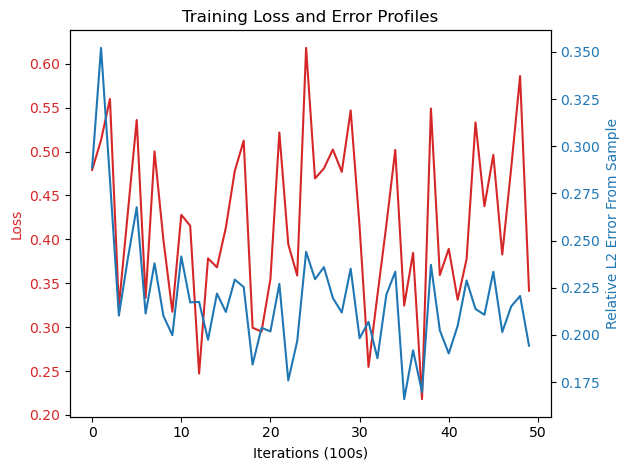

load from ckpt!


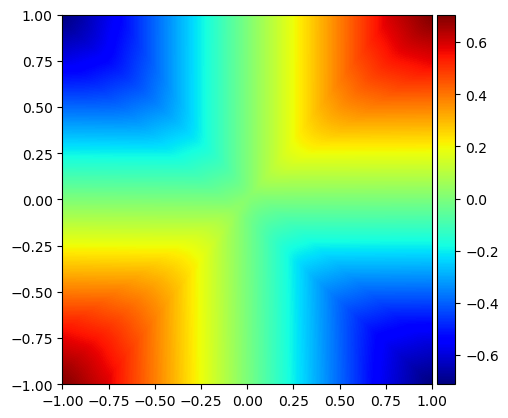

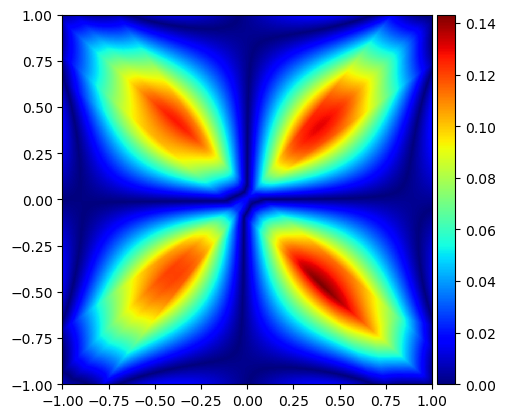

In [44]:
main_example1(domain='sq', arch='srnn_ReLU')

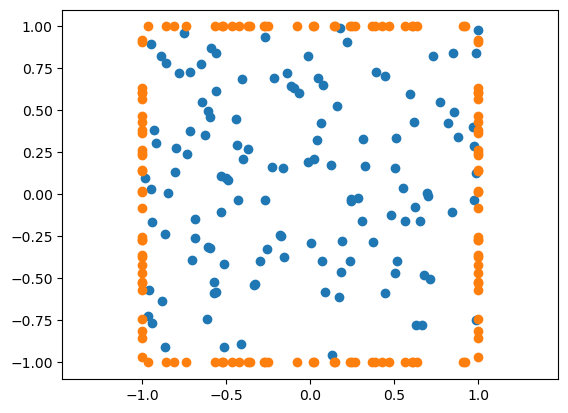

srnn_ReLU(
  (input): Linear(in_features=2, out_features=50, bias=True)
  (hidden): Linear(in_features=50, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


IntProgress(value=0, max=50)

best epoch: 4400 best loss: 0.2815990447998047 relative L2 error: 0.20462454855442047


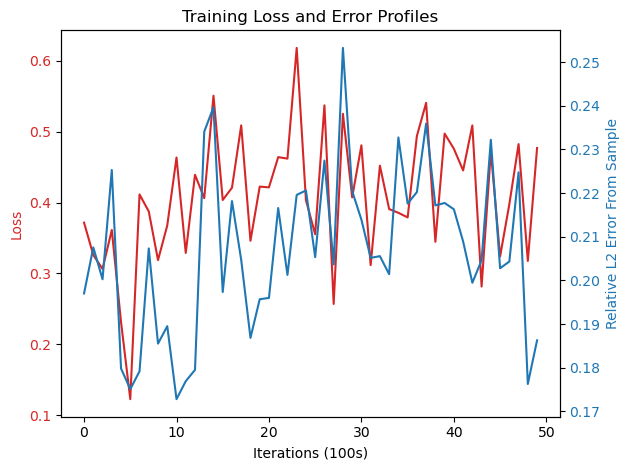

load from ckpt!


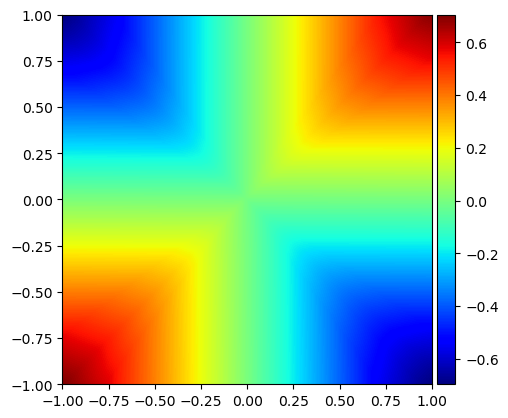

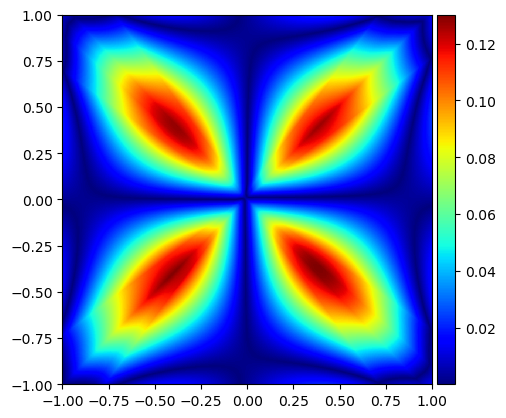

In [51]:
main_example1(domain='sq', arch='srnn_ReLU', m=50)

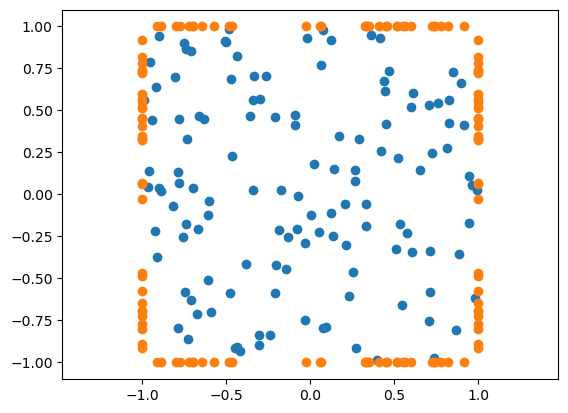

IntProgress(value=0, max=50)

best epoch: 5000 best loss: 0.3266669809818268 relative L2 error: 0.22504708170890808


In [45]:
main_example1(domain='sq', arch='srnn_ReLU', pretrain=2)

IntProgress(value=0, max=250)

best epoch: 23500 best loss: 0.20514634251594543 relative L2 error: 0.18958789110183716


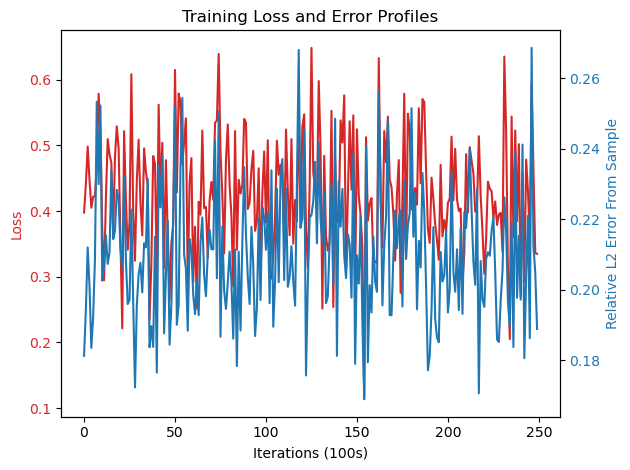

load from ckpt!


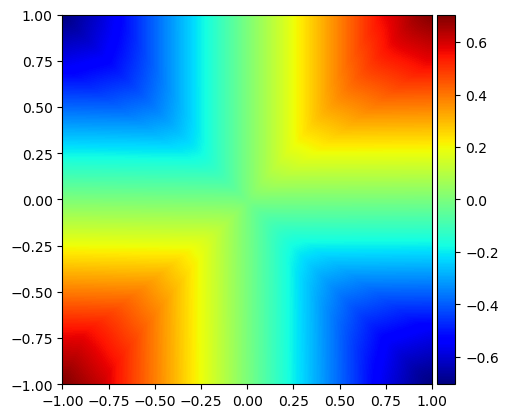

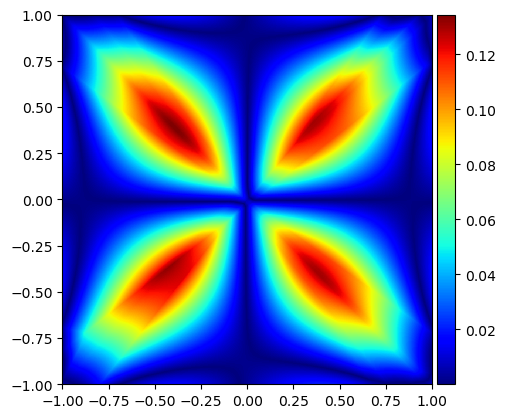

In [48]:
main_example1(domain='sq', arch='srnn_ReLU', epochs=25000, pretrain=1)

### Shallow Tanh

IntProgress(value=0, max=50)

best epoch: 4400 best loss: 0.16846385598182678 relative L2 error: 0.015894494950771332


load from ckpt!


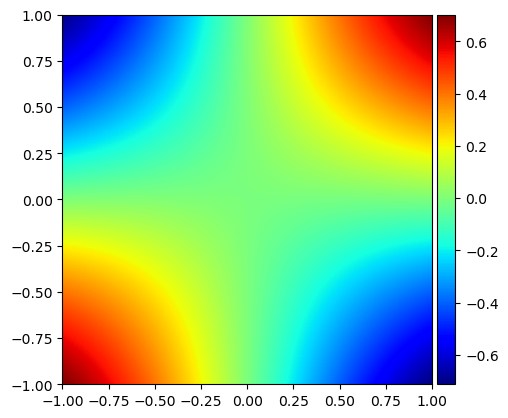

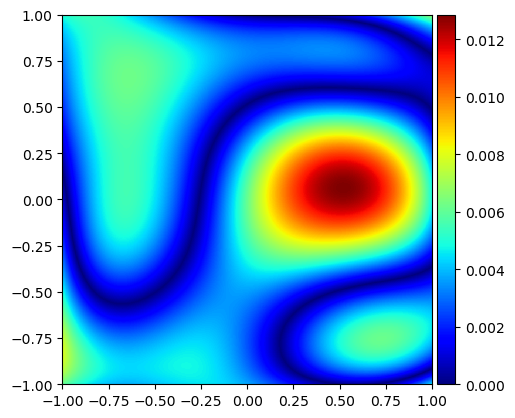

In [45]:
main_example1(domain='sq', arch='srnn_Tanh')

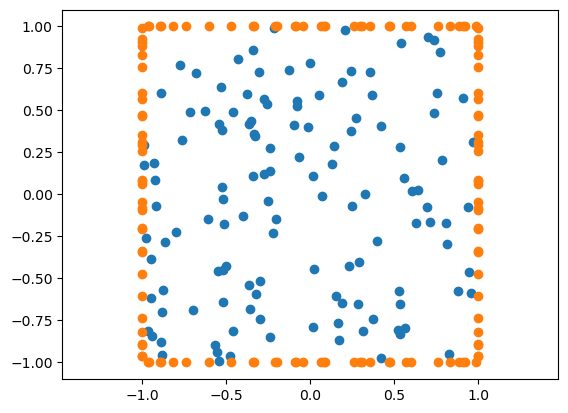

IntProgress(value=0, max=50)

best epoch: 4100 best loss: 0.0902111679315567 relative L2 error: 0.0147434426471591


In [49]:
main_example1(domain='sq', arch='srnn_Tanh', pretrain=2)

IntProgress(value=0, max=250)

best epoch: 22000 best loss: 0.011667285114526749 relative L2 error: 0.01142834685742855


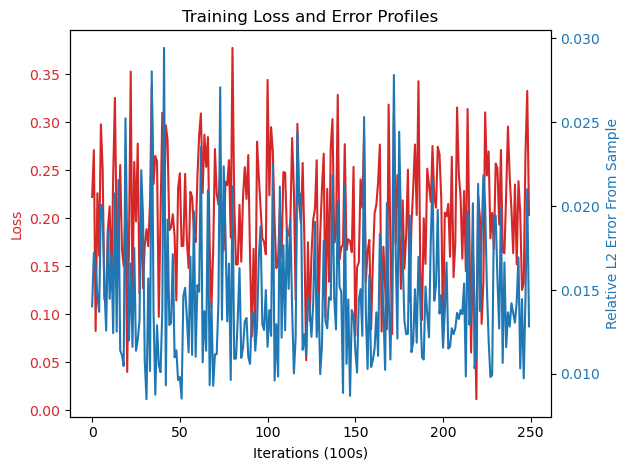

load from ckpt!


In [50]:
main_example1(domain='sq', arch='srnn_Tanh', epochs=25000, pretrain=1)

### Deep Residual ReLU

drrnn_ReLU(
  (stack): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): BlockReLU(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (2): BlockReLU(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (3): BlockReLU(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (4): BlockReLU(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)


IntProgress(value=0, max=50)

best epoch: 4600 best loss: 0.3467852771282196 relative L2 error: 0.20848359167575836
load from ckpt!


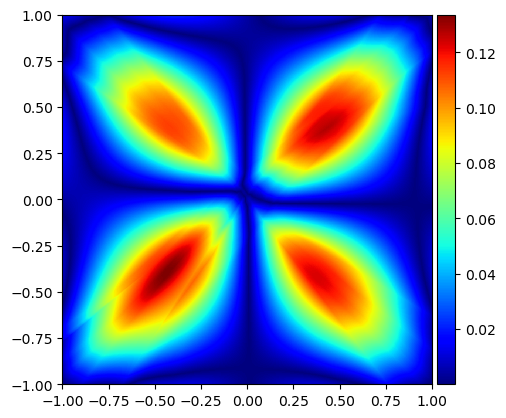

In [45]:
main_example1(domain='sq', arch='drrnn_ReLU')

In [ ]:
main_example1(domain='sq', arch='drrnn_ReLU', m=50)

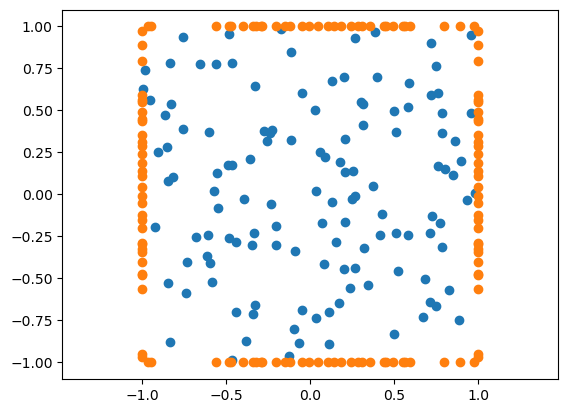

drrnn_ReLU(
  (stack): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (2): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (3): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (4): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
)


IntProgress(value=0, max=50)

best epoch: 4400 best loss: 0.18156711757183075 relative L2 error: 0.19718629121780396


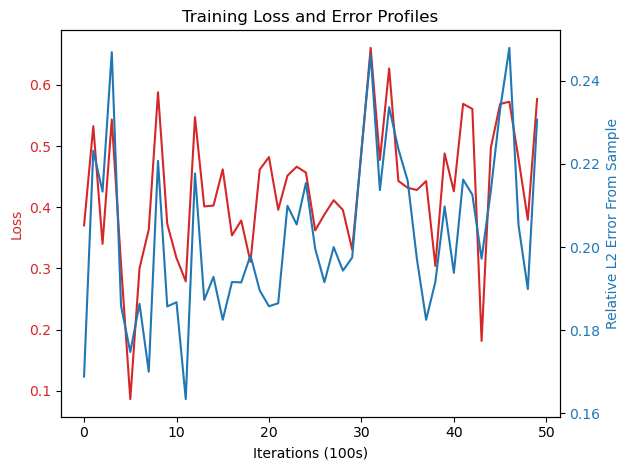

load from ckpt!


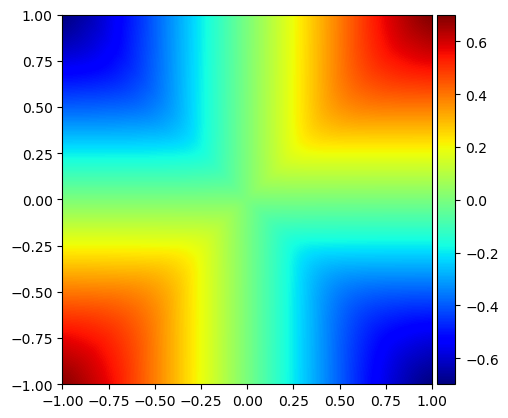

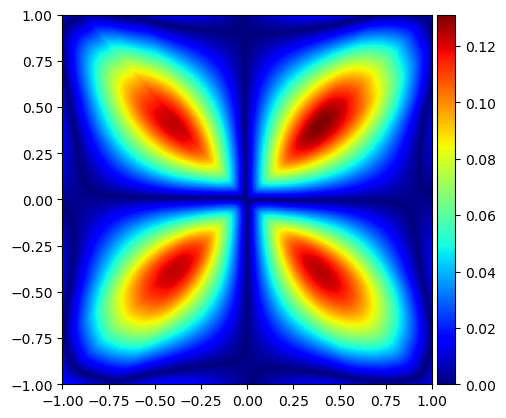

In [50]:
main_example1(domain='sq', arch='drrnn_ReLU', m=100)

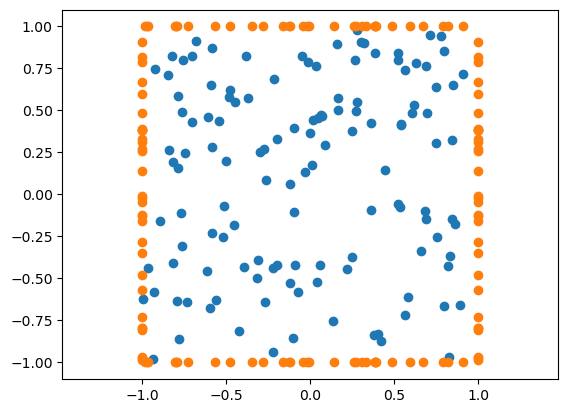

drrnn_ReLU(
  (stack): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (2): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (3): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (4): BlockReLU(
      (L1): Linear(in_features=100, out_features=100, bias=True)
      (L2): Linear(in_features=100, out_features=100, bias=True)
      (phi): ReLU()
    )
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
)


IntProgress(value=0, max=50)

best epoch: 4100 best loss: 0.26768141984939575 relative L2 error: 0.1804969757795334
load from ckpt!


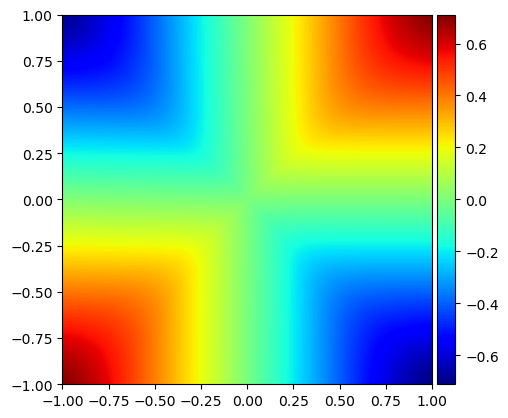

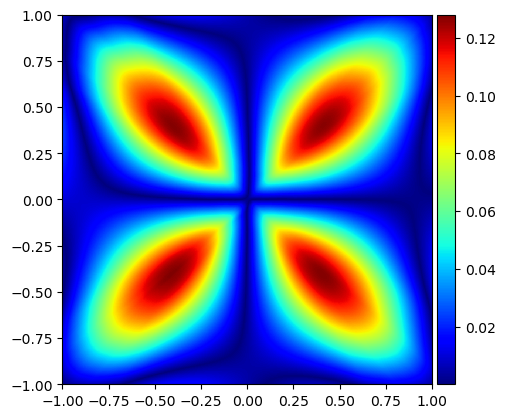

In [48]:
main_example1(domain='sq', arch='drrnn_ReLU', m=100)

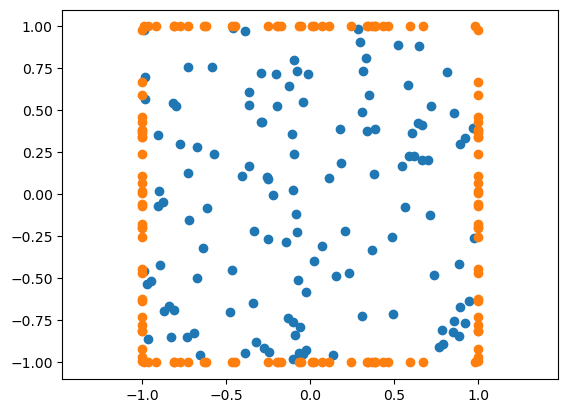

IntProgress(value=0, max=50)

best epoch: 4400 best loss: 0.04423217475414276 relative L2 error: 0.14472167193889618


In [51]:
main_example1(domain='sq', arch='drrnn_ReLU', pretrain=2)

IntProgress(value=0, max=250)

best epoch: 20200 best loss: 0.24567250907421112 relative L2 error: 0.18674513697624207


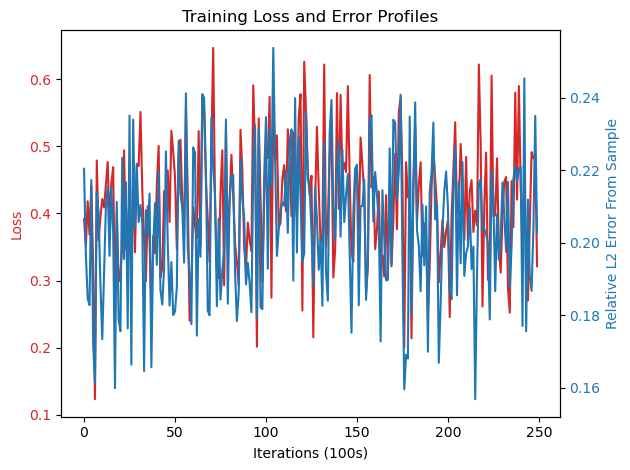

load from ckpt!


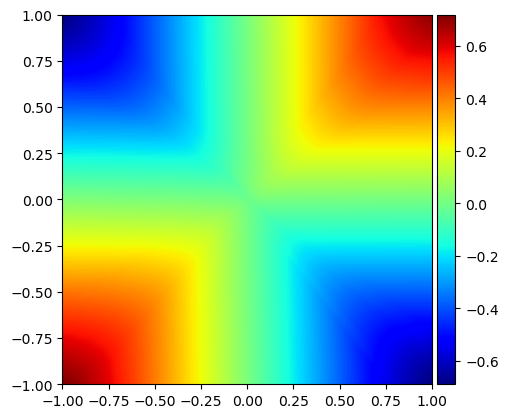

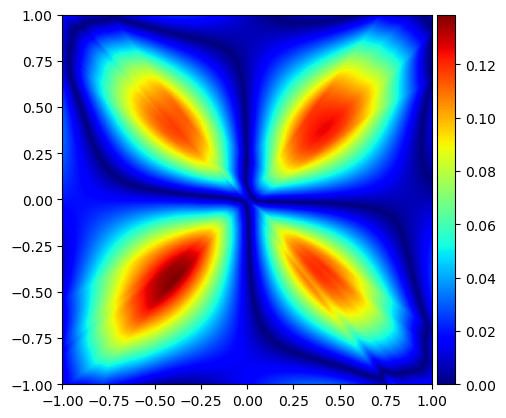

In [52]:
main_example1(domain='sq', arch='drrnn_ReLU', epochs=25000, pretrain=1)

### Deep Residual Tanh

IntProgress(value=0, max=50)

best epoch: 4200 best loss: 0.12469835579395294 relative L2 error: 0.032669104635715485


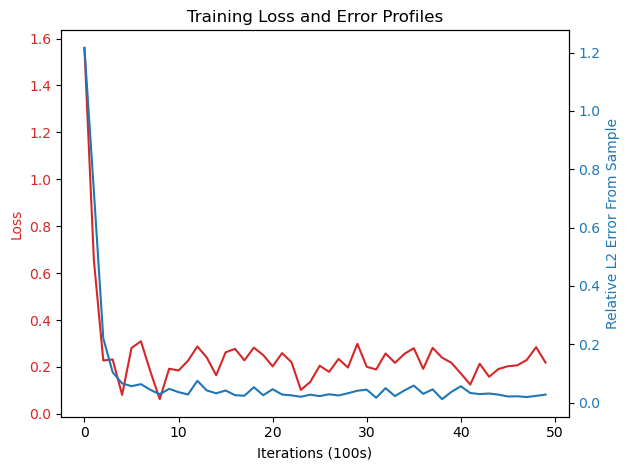

load from ckpt!


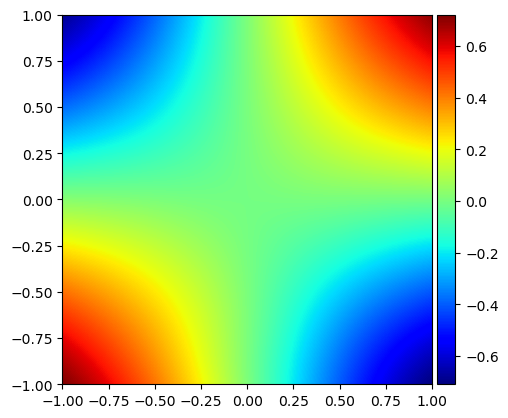

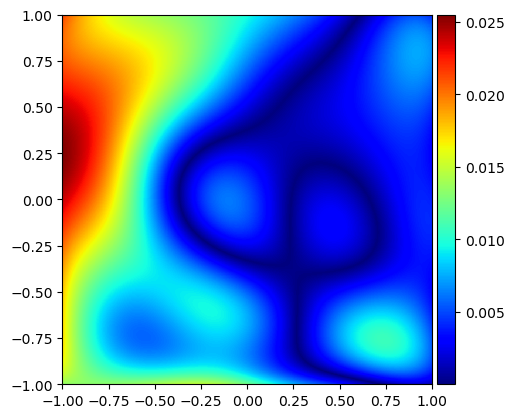

In [47]:
main_example1(domain='sq', arch='drrnn_Tanh')

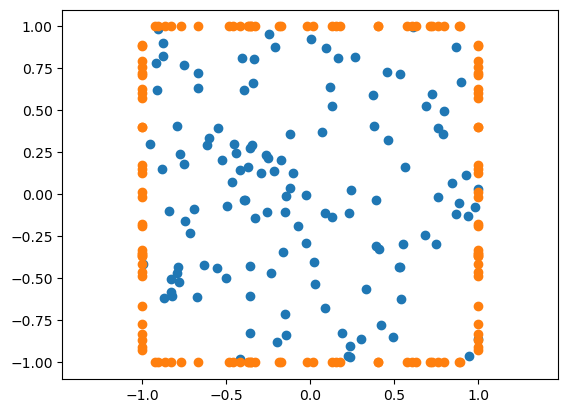

IntProgress(value=0, max=50)

best epoch: 4500 best loss: 0.1364530771970749 relative L2 error: 0.029012206941843033


In [53]:
main_example1(domain='sq', arch='drrnn_Tanh', pretrain=2)

IntProgress(value=0, max=250)

best epoch: 21900 best loss: 0.030397633090615273 relative L2 error: 0.015783997252583504


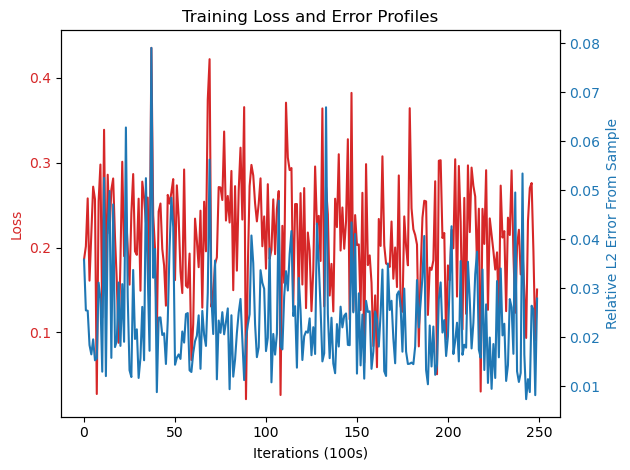

load from ckpt!


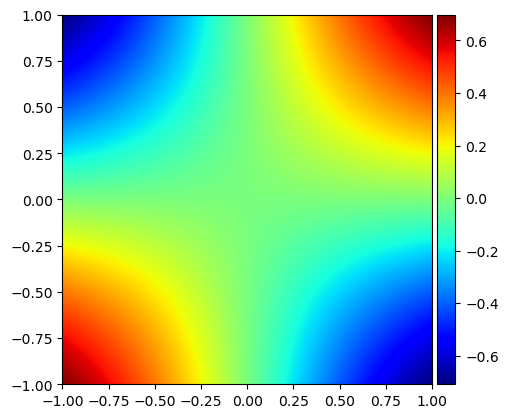

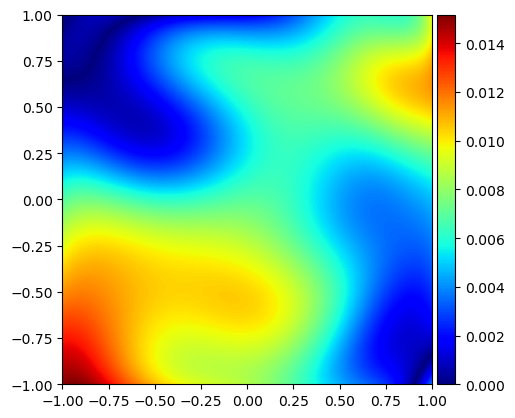

In [54]:
main_example1(domain='sq', arch='drrnn_Tanh', epochs=25000, pretrain=1)

### Deep Feedforward ReLU

IntProgress(value=0, max=50)

best epoch: 4800 best loss: 0.32471996545791626 relative L2 error: 0.22234269976615906


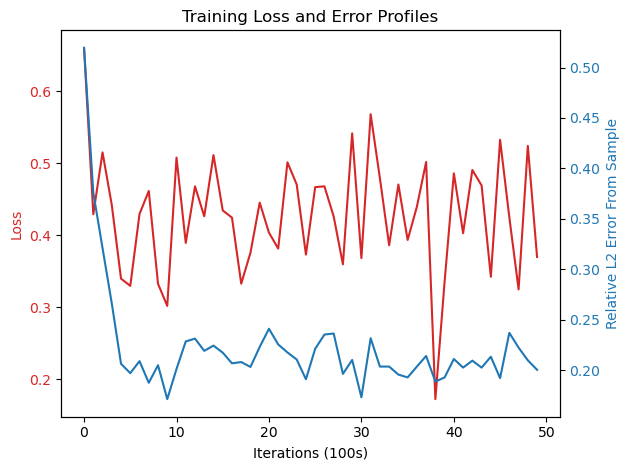

load from ckpt!


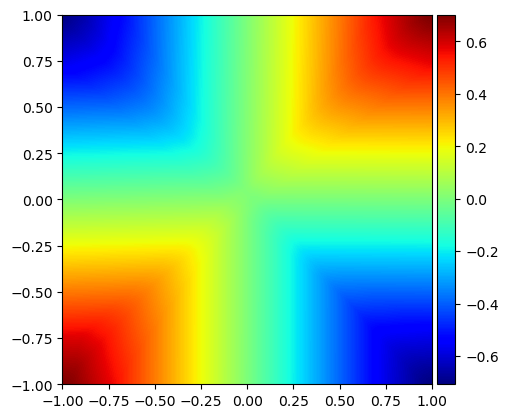

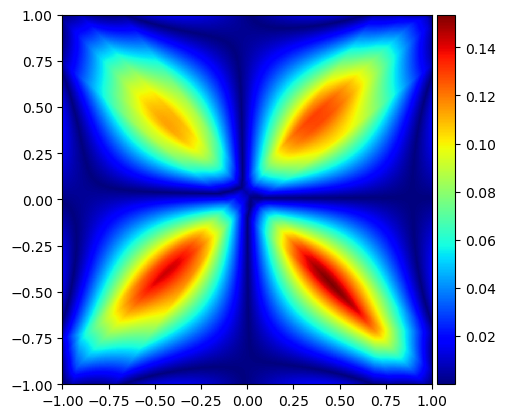

In [48]:
main_example1(domain='sq', arch='drfnn_ReLU')

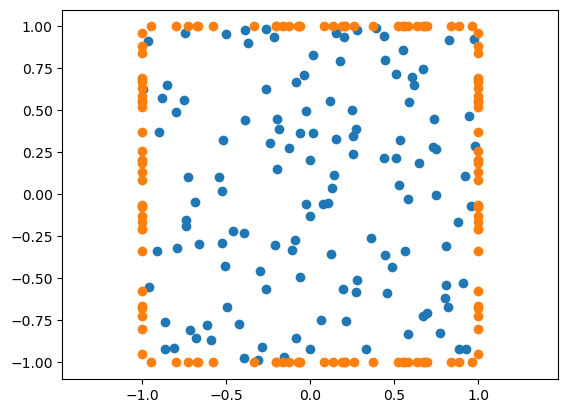

IntProgress(value=0, max=50)

best epoch: 4500 best loss: 0.3585965037345886 relative L2 error: 0.17500559985637665


In [55]:
main_example1(domain='sq', arch='drfnn_ReLU', pretrain=2)

IntProgress(value=0, max=250)

best epoch: 23400 best loss: 0.13443878293037415 relative L2 error: 0.18767628073692322


load from ckpt!


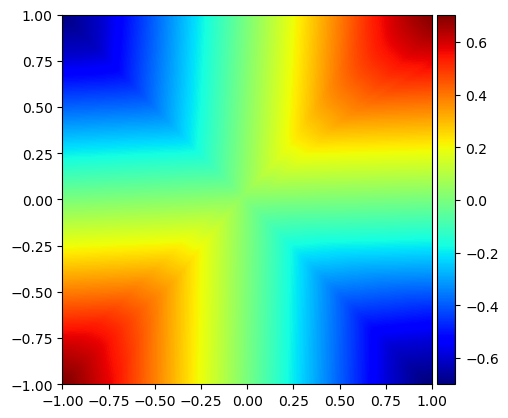

In [56]:
main_example1(domain='sq', arch='drfnn_ReLU', epochs=25000, pretrain=1)

### Deep Feedforward Tanh

IntProgress(value=0, max=50)

best epoch: 5000 best loss: 0.17608946561813354 relative L2 error: 0.020614534616470337


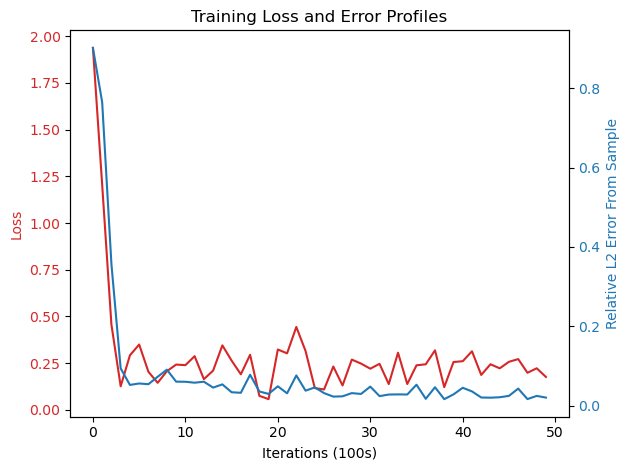

load from ckpt!


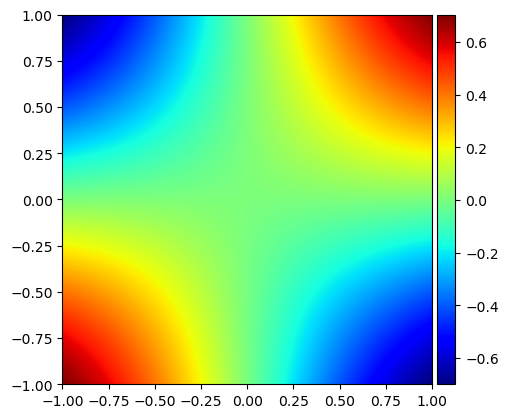

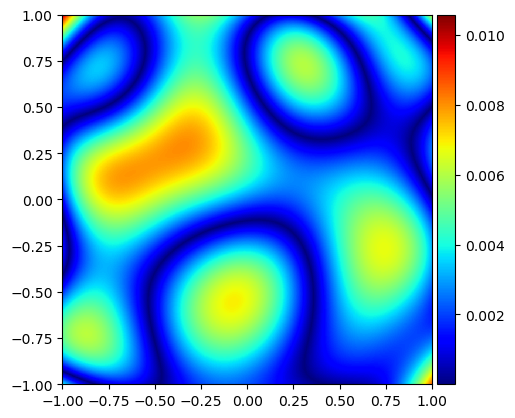

In [49]:
main_example1(domain='sq', arch='drfnn_Tanh')

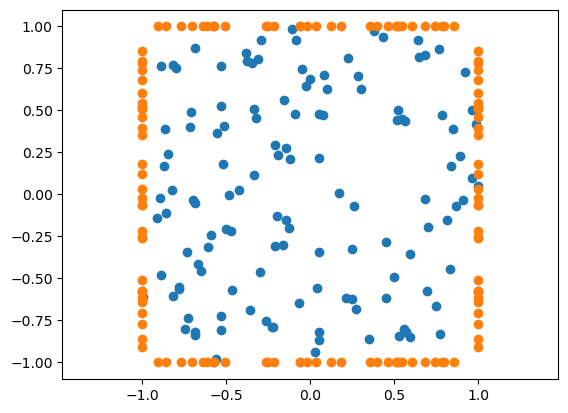

IntProgress(value=0, max=50)

best epoch: 4400 best loss: 0.08433188498020172 relative L2 error: 0.03797297552227974


In [57]:
main_example1(domain='sq', arch='drfnn_Tanh', pretrain=2)

IntProgress(value=0, max=250)

best epoch: 21400 best loss: 0.05476341396570206 relative L2 error: 0.019848883152008057


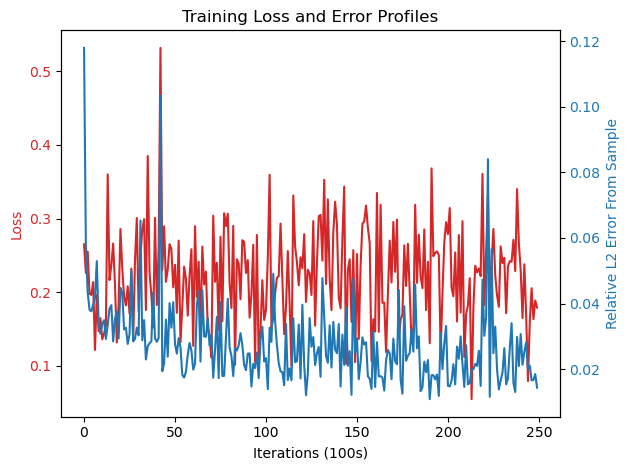

load from ckpt!


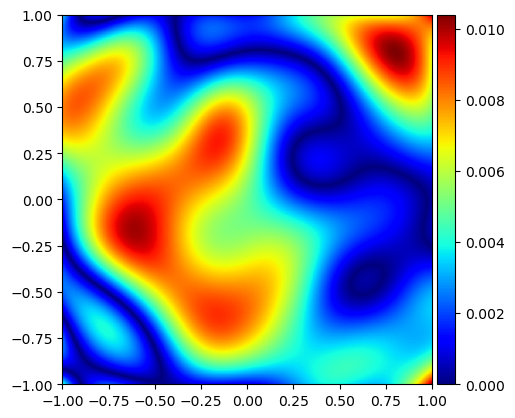

In [58]:
main_example1(domain='sq', arch='drfnn_Tanh', epochs=25000, pretrain=1)

--------------------------------------------------------------------------------------------------------------------------------